In [1]:
'''Robust SIMPLS Regression'''

__author__ = 'Maison Clouatre, Thitsa Laboratory'
__version__ = '0.0.4L'
__status__ = 'Prototype'
__date__ = 'November 20, 2020'


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m

In [24]:
# Define some useful functions

# Matrix element-wise absolute value
def mat_abs(X):
    rows, cols = np.shape(X)
    output = np.zeros([rows,cols])
    
    for i in range(rows):
        for j in range(cols):
            output[i][j] = abs(X[i][j])
    return output

# Matrix element-wise maximum
def mat_max(X,a):
    rows, cols = np.shape(X)
    output = np.zeros([rows,cols])
    
    for i in range(rows):
        for j in range(cols):
            output[i][j] = max(X[i][j],a)
    return output

# Matrix shrinkage function
def shrink(X, tau):
    rows, cols = np.shape(X)
    # Below, we use ELEMENT-WISE multiplication
    return np.multiply(np.sign(X), mat_max(mat_abs(X)-tau*np.ones([rows,cols]),0))

# Singular value shrinkage operator
def SVT(X, tau):
    # full_matrices=False below gives economy SVD
    U, S, V = np.linalg.svd(X,full_matrices=False)
    # The np.linalg.svd returns S as a VECTOR of s.v.'s, 
    # but we want a diagonal matrix.
    S = np.diag(S)
    # Notice the matrix multiplication function instead of
    # element-wise multiplication
    return U@shrink(S,tau)@V

def RPCA(X,lambda0=1):
    rows, cols = np.shape(X)
    # np.linalg.norm(X,1) is the l1 operator norm of X
    mu = rows*cols/(4*np.linalg.norm(X,1))
    lambda1 = lambda0/m.sqrt(max(rows,cols))
    # norm(X,'fro') is Frobenius norm
    thresh = 1e-7*np.linalg.norm(X,'fro')
    
    L = np.zeros([rows,cols])
    S = np.zeros([rows,cols])
    Y = np.zeros([rows,cols])
    count = 0
    
    while ((np.linalg.norm(X-L-S,'fro')>thresh) and (count<1000)):
        L = SVT(X-S + (1/mu)*Y, 1/mu)
        S = shrink(X-L + (1/mu)*Y, lambda1/mu)
        Y = Y + mu*(X-L-S)
        count = count + 1
        
    return L,S
        
def build_SIMPLS(Z,Y,rank=None,path_to_save=None, svthreshold=None):
    rowsZ, colsZ = np.shape(Z)
    rowsY, colsY = np.shape(Y)
    
    # Standardize predictors and responses
    Ztilde = np.zeros([rowsZ,colsZ])
    Ytilde = np.zeros([rowsY,colsY])
    
    meanZcols = np.mean(Z, axis=0)
    meanYcols = np.mean(Y, axis=0)
    stdZcols = np.std(Z, axis=0)
    stdYcols = np.std(Y, axis=0)
    
    for i in range(rowsZ):
        for j in range(colsZ):
            Ztilde[i][j] = Z[i][j]-meanZcols[j]
            if stdZcols[j] != 0:
              Ztilde[i][j] = Ztilde[i][j]/stdZcols[j]
    for i in range(rowsY):
        for j in range(colsY):
            Ytilde[i][j] = Y[i][j]-meanYcols[j]
            if stdYcols[j] != 0:
              Ytilde[i][j] = Ytilde[i][j]/stdYcols[j]
    
    # Compute SVD of correlation matrix
    U, E, V = np.linalg.svd(np.transpose(Ztilde)@Ytilde, full_matrices=False)
        
    # Because np.linalg.SVD is an interative method, it can result in tiny s.v.'s that should be zero. 
    # So, lets delete any singular values below some threshold.
    if svthreshold == None:
        svthreshold = 1e-3
    for i in range(np.size(E)):
        if E[i] < svthreshold:
            E = E[:i]
            break
    
    # If no rank is specified, use full-rank.
    if rank == None: 
        rank = np.size(E)
    
    T = np.zeros([rowsZ,rank])
    P = np.zeros([colsZ,rank])
    C = np.zeros([colsY,rank])
    
    # Build the SIMPLS model
    for i in range(rank):
        r = U[:,1]
        Zr = np.reshape(Ztilde@r,[rowsZ,1])
        T[:,[i]] = Zr/np.linalg.norm(Zr)
        P[:,[i]] = np.transpose(Ztilde)@T[:,[i]] #here the [i] forces this to be a column vector
        C[:,[i]] = np.transpose(Ytilde)@T[:,[i]]
        
        Ztilde = Ztilde - T[:,[i]]@np.transpose(T[:,[i]])@Ztilde
        Ytilde = Ytilde - T[:,[i]]@np.transpose(T[:,[i]])@Ytilde
        
        # If not the last loop
        if i!=rank-1:
            # Compute SVD of correlation matrix for next iteration
            U, E, V = np.linalg.svd(np.transpose(Ztilde)@Ytilde, full_matrices=False)

    model = np.linalg.pinv((np.transpose(P)))@np.transpose(C)
    
    # Now, we need to store the model and the descriptive statistics
    # of Y
    if path_to_save == None:
        path_to_save = r'C:\Users\maiso\Desktop\test_model'
    np.savez(path_to_save+'.npz', SIMPLS=model, stdYcols=stdYcols, meanYcols=meanYcols)
    
    return path_to_save

def predict_SIMPLS(Zs,path_to_model=None):
    rowsZs, colsZs = np.shape(Zs)
    
    # Standardize predictors
    Ztildes = np.zeros([rowsZs,colsZs])
    meanZscols = np.mean(Zs, axis=0)
    stdZscols = np.std(Zs, axis=0)
    for i in range(rowsZs):
        for j in range(colsZs):
            Ztildes[i][j] = Zs[i][j]-meanZscols[j]
            if stdZscols[j] != 0:
              Ztildes[i][j] = Ztildes[i][j]/stdZscols[j]
    
    # Load model
    if path_to_model == None:
        path_to_model = r'C:\Users\maiso\Desktop\test_model.npz'
    savedData = np.load(path_to_model)
    
    meanYcols = savedData['meanYcols']
    stdYcols = savedData['stdYcols']
    model = savedData['SIMPLS']
    
    # Predict responses using model
    Ys = Ztildes@model
    
    # De-standardize the responses using descriptive statistics from training
    rowsYs, colsYs = np.shape(Ys)
    for i in range(rowsYs):
        for j in range(colsYs):
            Ys[i][j] = Ys[i][j]*stdYcols[j]+meanYcols[j]
    return Ys

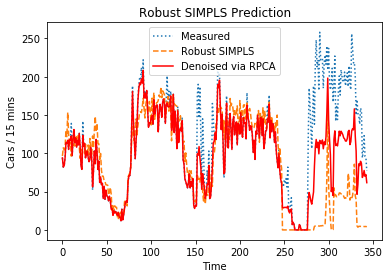

It took 7.521922826766968 seconds to load data, build model, predict, and plot the results.


In [25]:
import time
start = time.time()

# Load and de-noise data
A = np.array(pd.read_excel(r'C:\Users\maiso\Desktop\Rename.xlsx'))
rows, cols = np.shape(A)

L,S = RPCA(A[:-1,:]) # Here, we take out the last row... 
                     # it will be used during validation of the model. This is just an example, of course.
Z = L[:,:40]
Y = L[:,40:]

# Train a test model
build_SIMPLS(Z,Y)

# Load test data
# Append new predictor variables to Z
Z = np.vstack((Z,A[-0,:40]))

# Predict using a test model
Prediction = predict_SIMPLS(Z)

# For comparison to model, denoise data after response variable is collected 
L, S = RPCA(A)

# Plot the prediction versus actual
[rowsY,colsY] = np.shape(Y)
Time = [i for i in range(colsY)]
plt.title("Robust SIMPLS Prediction") 
plt.xlabel("Time") 
plt.ylabel("Cars / 15 mins") 
plt.plot(Time,A[-1,40:],':')
plt.plot(Time,Prediction[-1,:],'--')
plt.plot(Time,L[-1,40:],'r') 
plt.legend(('Measured','Robust SIMPLS','Denoised via RPCA'))
plt.show()

print('It took', time.time()-start, 'seconds to load data, build model, predict, and plot the results.')